# Multimodal Entailment

[Original Keras Code](https://keras.io/examples/nlp/multimodal_entailment/)

<br/>

**Author**: Yookyung Kho

**Date presented**: 2022/01/17, DSBA keras2torch Study

**Task description**: Multi-Label Classification, Training a multimodal model for predicting entailment.

> You can check a whole python script pipeline for multimodal entailment(pytorch) in [this github repository](https://github.com/yookyungkho/Multimodal-Entailment-pytorch).

**References**:

- https://github.com/google-research-datasets/recognizing-multimodal-entailment

- https://multimodal-entailment.github.io/


---

## About Multimodal Entailment

- [Recognizing Multimodal Entailment](https://multimodal-entailment.github.io/): Tutorial presented at `ACL 2021`

On social media platforms, to audit and moderate content we may want to find answers to the following questions in near real-time:

    > Does a given piece of information "contradict" the other?
    > Does a given piece of information "imply" the other?

In NLP, this task is called analyzing **textual entailment**. However, that's only when the information comes from text content. In practice, it's often the case the information available comes not just from text content, but from a multimodal combination of text, images, audio, video, etc. **Multimodal entailment** is simply the extension of textual entailment to **a variety of new input modalities**.

- **Input**: 2 text,image pairs (`text_1`, `image_1`), (`text_2`, `image_2`)
- **Output**: 3 classes(`Implies`, `NoEntailment`, `Contradictory`)

![image](multimodal.png)

---

## 0. Import

In [1]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchinfo import summary

import torchtext
from torchtext.utils import download_from_url
import torchvision

from transformers import AutoTokenizer

In [2]:
import torch
print(torch.__version__)

1.10.2+cu102


In [3]:
import torchtext
print(torchtext.__version__)

0.11.0


## 1. Data Preprocessing

**Data description**

- [multimodal entailment dataset](https://github.com/google-research-datasets/recognizing-multimodal-entailment) recently introduced by Google Research

- The original dataset is available here. It comes with URLs of images which are hosted on Twitter's photo storage system called the Photo Blob Storage (PBS for short). We will be working with the downloaded images along with additional data that comes with the original dataset.

### 1.1. Data Download

In [4]:
import os

path = 'data/' # 현재 디렉토리에 data 폴더 추가

if not os.path.exists(path):
    os.mkdir(path)

In [6]:
from torchtext.utils import download_from_url

url = "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/releases/download/v1.0.0/tweet_images.tar.gz"
download_from_url(url, path=None, root=path, overwrite=False, hash_value=None, hash_type='sha256')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 344M/344M [00:50<00:00, 6.87MB/s]


'/workspace/codes/keras2torch_study/multimodal/data/tweet_images.tar.gz'

In [7]:
import tarfile

tar = tarfile.open(path+"tweet_images.tar.gz", "r:gz")
tar.extractall(path)
tar.close()

In [5]:
import pandas as pd

df = pd.read_csv("https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/tweets.csv")
df.sample(5)

,id_1,text_1,image_1,id_2,text_2,image_2,label
653,1376568655857602566,Barack Obama speaks out following the passing ...,http://pbs.twimg.com/media/ExqN5ZzUYAMEZ46.jpg,1376604080840175620,Barack Obama Mourning Death of Beloved Grandmo...,http://pbs.twimg.com/media/ExquHcjVgAELk3f.jpg,NoEntailment
647,1333893428367781890,There were no winners to tonight's club lotto....,http://pbs.twimg.com/media/EoLw_XIWMAIF0bg.jpg,1336431970373558273,There was no winner of this week's club lotto....,http://pbs.twimg.com/media/Eov1yTaXYAIgubh.jpg,NoEntailment
1257,1339225227046350848,"15:00:Temp: 7.5°C, Wind: S, 171°, 10mph, 18mph...",http://pbs.twimg.com/media/EpXiPtFXIAI65nk.jpg,1363183542398824453,"17:47:Temp: 11.2°C, Wind: S, 176°, 20mph, 38mp...",http://pbs.twimg.com/media/EusANN3WgAMelTX.jpg,NoEntailment
21,1378117789722931201,BOOM! These are my picks I just made on @foxsu...,http://pbs.twimg.com/media/EyAO0ypUcAMwDU7.jpg,1381240499571453957,BOOM! These are my picks I just made on @foxsu...,http://pbs.twimg.com/media/Eysm6a1WgAA1VVE.jpg,Implies
614,1335081080357994499,UPSC &amp; State PSC Mains Practice Questions ...,http://pbs.twimg.com/media/EocpAE5UUAAQbUg.jpg,1355012873248890880,UPSC &amp; State PSC Mains Practice Questions\...,http://pbs.twimg.com/media/Es345dOU0AADrQm.jpg,NoEntailment


In [6]:
df.shape

(1400, 7)

The entailment task is formulated as the following:

> Given the pairs of (`text_1`, `image_1`) and (`text_2`, `image_2`), do they **entail (or not entail or contradict)** each other?

We have the images already downloaded. `image_1` is downloaded as `id_1` as its filename and `image_2` is downloaded as `id_2` as its filename. In the next step, we will _add two more columns_ to df - _filepaths_ of `image_1`s and `image_2`s.

In [7]:
image_base_path = path + "tweet_images/"
images_one_paths = []
images_two_paths = []

for idx in range(len(df)):
    current_row = df.iloc[idx]
    id_1 = current_row["id_1"]
    id_2 = current_row["id_2"]
    extentsion_one = current_row["image_1"].split(".")[-1] #jpg
    extentsion_two = current_row["image_2"].split(".")[-1]

    image_one_path = os.path.join(image_base_path, str(id_1) + f".{extentsion_one}") #ex) 'data/tweet_images/1375936088968200205.jpg'
    image_two_path = os.path.join(image_base_path, str(id_2) + f".{extentsion_two}")

    images_one_paths.append(image_one_path)
    images_two_paths.append(image_two_path)

df["image_1_path"] = images_one_paths
df["image_2_path"] = images_two_paths

# Defien label map
label_map = {"Contradictory": 0, "Implies": 1, "NoEntailment": 2}
# Create another column containing the integer ids of the string labels.
df["label_idx"] = df["label"].apply(lambda x: label_map[x])

In [8]:
df.head()

,id_1,text_1,image_1,id_2,text_2,image_2,label,image_1_path,image_2_path,label_idx
0,1375936088968200205,"150 years after its inauguration, the strategi...",http://pbs.twimg.com/media/ExeIVRBWYAAwizQ.jpg,1376653595144241155,Look how only 190 km #suezcanel carries 12% of...,http://pbs.twimg.com/media/ExrbJffWgAoBaxO.jpg,NoEntailment,data/tweet_images/1375936088968200205.jpg,data/tweet_images/1376653595144241155.jpg,2
1,1360981123388436489,Fall Guys is celebrating Valentine's Day with ...,http://pbs.twimg.com/media/EuMowPiXYAEylR8.jpg,1361075903606910976,Fall Guys Red Panda costume available for limi...,http://pbs.twimg.com/media/EuODUixWYAMRukK.jpg,NoEntailment,data/tweet_images/1360981123388436489.jpg,data/tweet_images/1361075903606910976.jpg,2
2,1336637206899945472,Impressive Batting Display From Shoaib Malik 🏏...,http://pbs.twimg.com/media/EoywcVGXMAE5FZK.jpg,1339243901799030785,"A Half century of King\n\n 🔥""Shoaib Malik"" ...",http://pbs.twimg.com/media/EpXzOwRXYAYLaCB.jpg,NoEntailment,data/tweet_images/1336637206899945472.jpg,data/tweet_images/1339243901799030785.jpg,2
3,1336490796279742464,How #confident are you today? https://t.co/5ay...,http://pbs.twimg.com/media/EowrS9aVEAAMhsF.jpg,1341081069248868353,How #confident are you today? https://t.co/KqZ...,http://pbs.twimg.com/media/Epx6IA-UwAA8pqN.jpg,Implies,data/tweet_images/1336490796279742464.jpg,data/tweet_images/1341081069248868353.jpg,1
4,1358934899256877059,The Peacocks finish out the first quarter trai...,http://pbs.twimg.com/media/EtvoCsuWQAALmyP.jpg,1361131487077228546,10 minutes gone here at home as the Peacocks l...,http://pbs.twimg.com/media/EuO1xf2XIAAOIGb.jpg,NoEntailment,data/tweet_images/1358934899256877059.jpg,data/tweet_images/1361131487077228546.jpg,2


### 1.2. Data Visualization

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(idx):
    current_row = df.iloc[idx]
    image_1 = plt.imread(current_row["image_1_path"])
    image_2 = plt.imread(current_row["image_2_path"])
    text_1 = current_row["text_1"]
    text_2 = current_row["text_2"]
    label = current_row["label"]
    
    # image1
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image One")
    plt.show()
    # text1
    print("========="*10)
    print(f"Text1: {text_1}")
    print("========="*10)
    
    # image2
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 2)
    plt.imshow(image_2)
    plt.axis("off")
    plt.title("Image Two")
    plt.show()
    # text2
    print("========="*10)
    print(f"Text2: {text_2}")
    print("========="*10)
    
    # label
    print(f">>>>> Label: {label}")
    print("========="*10)

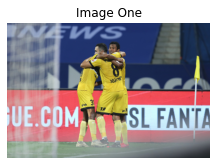

Text1: #HyderabadFC's two-goal cushion is restored as Joao Victor makes it 3-1 with a peach of a finish. 

 Follow #CFCHFC live: https://t.co/FDFVZy9cNv #ISL https://t.co/bH5nazqeEc


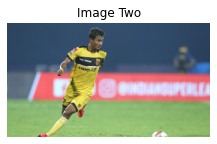

Text2: #HyderabadFC is making merry here! Halicharan Narzary bags his second goal of the evening to hand his side a 4-1 lead. 

Follow #CFCHFC live: https://t.co/FDFVZy9cNv #ISL https://t.co/0iBUxjUk9D
>>>>> Label: NoEntailment


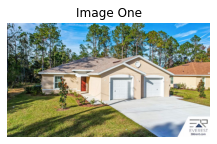

Text1: 🚨 🏡 RENTAL HOUSE! LIKE NEW 3/2/1 IN THE HEART OF PALM COAST, FLORIDA

👉 https://t.co/p77rBODlba

#realestate  #realestateinvestor #realestatebroker #landlords #rentalproperty #propertyforrent #propertymanagement #386rent #PalmCoastPropertyManagement #EverestRealty https://t.co/kYv83AkCRu


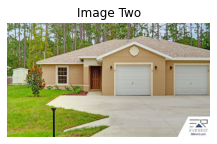

Text2: 🚨 🏡 RENTAL HOUSE! LIKE NEW 3/2/1 IN THE HEART OF PALM COAST FLORIDA

👉 https://t.co/XMbG0zFzlF

#realestate  #RealEstateAgent #realestateinvestor  #rentalproperty  #propertydevelopment #propertyforrent #propertymanagement #386rent #PalmCoastPropertyManagement #EverestRealty https://t.co/EBRbI6Ewza
>>>>> Label: Implies


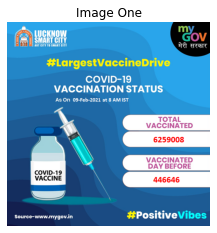

Text1: #COVID19 Vaccination Tracker
(upto 09th February, 2021 till 08:00 AM)
#LargestVaccineDrive
#StayAlert
#StaySafe https://t.co/JmMMayb8hn


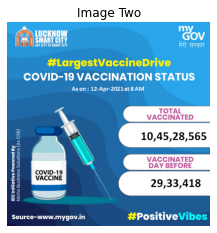

Text2: #COVID19 Vaccination Tracker
#LargestVaccineDrive
#StayAlert
#StaySafe https://t.co/eo8wP3Fcdy
>>>>> Label: Contradictory


In [77]:
visualize(1395) #NoEntailment(Neutural)
visualize(12) #Implies
visualize(13) #Contradictory

### 1.3. Data Split

The dataset suffers from class imbalance problem.

In [10]:
df["label"].value_counts()

NoEntailment     1182
Implies           109
Contradictory     109
Name: label, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

# stratified split (consider number of labels in train/val/test set)

# 10% for test
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df["label"].values, random_state=42)
# 4.5% for validation, 85.5% for train
train_df, val_df = train_test_split(train_df, test_size=0.05, stratify=train_df["label"].values, random_state=42)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 1197
Total validation examples: 63
Total test examples: 140


### 1.4. Multi-modal Dataset, Dataloader

**Input Batch**: text_inputs, image_inputs, labels

**1. Text Inputs**
```
{'input_ids': tensor(batch_size, 128),  'token_type_ids': tensor(batch_size, 128),  'attention_mask': tensor(batch_size, 128)}
```
- 'input ids': [CLS] text1 [SEP] text2 [SEP]
    - [CLS]: 101, [SEP]: 102 
    - max_length = 128, padding = 0
- 'token_type_ids': text1(0), text2(1)
- 'attention_mask': all 1 in text positions

**2. Image Inputs**
```
{'image1': tensor(batch_size, 3, 128, 128),  'image2': tensor(batch_size, 3, 128, 128)}
```
- color image -> resize(128) -> to tensor

**3. Labels**
```
tensor(batch_size,)
```
             

In [12]:
### Dataset

from transformers import AutoTokenizer
import torchvision
from PIL import Image

class MultiModal_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, img_size=128):
        
        # text
        self.text1 = df["text_1"].tolist()
        self.text2 = df["text_2"].tolist()
        self.tokenizer = tokenizer
        
        # image
        self.image1 = df["image_1_path"].tolist()
        self.image2 = df["image_2_path"].tolist()
        self.img_transform = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(img_size, img_size)),
                                                             torchvision.transforms.ToTensor()])
        #label
        self.label = df["label_idx"].tolist()
    
    def __len__(self):
        return len(self.text1)
    
    def __getitem__(self, idx):
        
        # text inputs
        text1 = self.text1[idx]
        text2 = self.text2[idx]
        text_inputs = self.tokenizer(text1, text2, padding="max_length", truncation=True, max_length=128, return_tensors="pt") #batch별 max_len 자동 커스텀화
        
        # image inputs
        ## number of channels are different depending on the image mode
        ### If the input has 4 channels, the ``mode`` is assumed to be ``RGBA``.
        ### If the input has 3 channels, the ``mode`` is assumed to be ``RGB``.
        ### If the input has 2 channels, the ``mode`` is assumed to be ``LA``.
        ##### https://pytorch.org/vision/main/_modules/torchvision/transforms/transforms.html#ToPILImage
        ##### https://stackoverflow.com/questions/9166400/convert-rgba-png-to-rgb-with-pil
        image1 = Image.open(self.image1[idx]).convert("RGB")
        image1 = self.img_transform(image1)
        image2 = Image.open(self.image2[idx]).convert("RGB")
        image2 = self.img_transform(image2)
        image_inputs = {'image1': image1, 'image2': image2}
        
        # labels
        labels = self.label[idx]
        
        return text_inputs, image_inputs, labels
        

---

## 2. Modeling

The model consists of the following elements:

![image](multimodal.png)


- A standalone encoder for the images. We will use a **ResNet50** pre-trained on the ImageNet-1k dataset for this.(torchvision)

- A standalone encoder for the texts. A pre-trained **BERT** will be used for this.(huggingface transformers)

After extracting the individual embeddings, they will be projected in an identical space. Finally, their projections will be concatenated and be fed to the final classification layer.

Model Architecture

- text encoder
- vision encoder
- projection(text, vision)
- Dense(3)

In [13]:
## GPU check
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

True
NVIDIA GeForce RTX 2080 Ti
1


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 2.0. projection embeddings

In [15]:
class Project_Embeddings_one_layer(nn.Module):
    def __init__(self, projection_dim=256, dropout_rate=0.2):
        super().__init__()
        self.gelu_linear_dropout = nn.Sequential(nn.GELU(),
                                                 nn.Linear(projection_dim, projection_dim),
                                                 nn.Dropout(dropout_rate))
        self.layer_norm = nn.LayerNorm(projection_dim)
        
    def forward(self, input_x):
        x = self.gelu_linear_dropout(input_x)
        x = x + input_x #residual connection
        x = self.layer_norm(x)
        return x

In [16]:
class Project_Embeddings(nn.Module):
    def __init__(self, num_projection_layers=3, hidden_dim=768, projection_dim=256, dropout_rate=0.2):
        super().__init__()
        self.first_layer = nn.Linear(hidden_dim, projection_dim)
        self.embedding_layers = nn.ModuleList([Project_Embeddings_one_layer() for i in range(num_projection_layers)])
        
    def forward(self, embeddings):
        output = self.first_layer(embeddings)
        for layer in self.embedding_layers:
            output = layer(output)
        return output  

### 2.1. Text Encoder

[CLS]: 101, [SEP]: 102

- input: type_ids (batch_size, 128), mask (batch_size, 128), word_ids (batch_size, 128)
- BERT (trainable?)
- projection
    - Dense
    - gelu -> Dense -> Dropout -> Add(residual connection) -> Layer Normalization (num_layers 만큼 반복)
    - output: (batch_size, 256)

In [21]:
from transformers import AutoConfig

# pretrained 모델과 동일한 config
model_config = AutoConfig.from_pretrained('bert-base-uncased')
model_config

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.5.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [17]:
from transformers import (AutoTokenizer, AutoModel)

class Text_Encoder_BERT(nn.Module):
    def __init__(self, model_name, trainable=False, num_projection_layers=2, hidden_dim=768, projection_dim=256, dropout_rate=0.2, device=device):
        super().__init__()
        self.model_name = model_name
        
        self.text_encoder = AutoModel.from_pretrained(model_name) # fine tuning 여부 체크!
        
        for param in self.text_encoder.parameters():
            param.requires_grad = trainable
        
        self.projection = Project_Embeddings(num_projection_layers=2, hidden_dim=768, projection_dim=256, dropout_rate=0.2)
        
    def forward(self, input_ids, token_type_ids, attention_mask):

        text_inputs = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask':attention_mask}
        
        bert_embedding = self.text_encoder(**text_inputs)
        
        cls_output = bert_embedding.pooler_output
        
        output = self.projection(cls_output)
        
        return output #torch.Size([batch_size, 256])

In [59]:
from torchinfo import summary

text_encoder_bert = Text_Encoder_BERT(model_name=model_name, num_projection_layers=2, hidden_dim=768, projection_dim=256, dropout_rate=0.2)
summary(text_encoder_bert)

Layer (type:depth-idx)                                  Param #
Text_Encoder_BERT                                       --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─Embedding: 3-3                              (1,536)
│    │    └─LayerNorm: 3-4                              (1,536)
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             (85,054,464)
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 (590,592)
│    │    └─Tanh: 3-8                                   --
├─Project_Embeddings: 1-2                               --
│    └─Linear: 2-4                                      196,864
│ 

---

### 2.2. Vision Encoder

- input: image1 (batch_size, 128, 128, 3), image2 (batch_size, 128, 128, 3)
- embedding 1 (resnet for embedding image 1) -> avg pooling
- embedding 2 (resnet for embedding image 2) -> avg pooling
    - avg means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.
- concatenate embedding 1 & embedding 2
- projection
    - Dense
    - gelu -> Dense -> Dropout -> Add(residual connection) -> LayerNormalization (num_layers 만큼 반복)
    - output: (batch_size, 256)

In [18]:
import torchvision

class Image_Encoder_ResNet(nn.Module):
    def __init__(self, trainable=False):
        super().__init__()
        
        resnet_image1 = torchvision.models.resnet50(pretrained=True)
        self.resnet_image1 = nn.Sequential(*list(resnet_image1.children())[:-1]) # remove linear classifier
        
        resnet_image2 = torchvision.models.resnet50(pretrained=True)
        self.resnet_image2 = nn.Sequential(*list(resnet_image2.children())[:-1])
        
        for param1, param2 in zip(self.resnet_image1.parameters(), self.resnet_image2.parameters()):
            param1.requires_grad = trainable
            param2.requires_grad = trainable
        
        self.projection = Project_Embeddings(num_projection_layers=1, hidden_dim=4096, projection_dim=256, dropout_rate=0.2)
        
    def forward(self, image1, image2):
        # image_inputs = {'image1': tensor(B,3,128,128), 'image2': tensor(B,3,128,128)}
        
        output1 = self.resnet_image1(image1) # (B,C,1,1)
        output2 = self.resnet_image2(image2) # (B,C,1,1)
        
        concat = torch.cat((output1, output2), dim=1) # (B,2C,1,1)
                        
        batch_size = concat.size(0)
        output = concat.view((batch_size, 4096)) # (B,2C)
        
        output = self.projection(output)
        return output

In [60]:
#
res = Image_Encoder_ResNet()
summary(res, ((1,3,128,128),(1,3,128,128)))

Layer (type:depth-idx)                             Output Shape              Param #
Image_Encoder_ResNet                               --                        --
├─Project_Embeddings: 1                            --                        --
│    └─ModuleList: 2-1                             --                        --
├─Sequential: 1-1                                  [1, 2048, 1, 1]           --
│    └─Conv2d: 2-2                                 [1, 64, 64, 64]           (9,408)
│    └─BatchNorm2d: 2-3                            [1, 64, 64, 64]           (128)
│    └─ReLU: 2-4                                   [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-5                              [1, 64, 32, 32]           --
│    └─Sequential: 2-6                             [1, 256, 32, 32]          --
│    │    └─Bottleneck: 3-1                        [1, 256, 32, 32]          (75,008)
│    │    └─Bottleneck: 3-2                        [1, 256, 32, 32]          (70,400)
│    │    └─Bot

### 2.3. Multi-modal Classification Layer

- concatenate text projection (batch_size, 256) & image projection (batch_size, 256) -> output: (batch_size, 512)
- 3 classes: `NoEntailment`, `Implies`, `Contradictory`
- Dense layer: input (batch_size, 512) -> output (batch_size, 3)

In [19]:
class MultiModal_Classification(nn.Module):
    def __init__(self, text_model_name = 'bert-base-uncased', text_trainable=False, image_trainable=False, projection_dim=256, num_class=3):
        super().__init__()
        self.text_encoder = Text_Encoder_BERT(model_name=text_model_name, trainable=text_trainable, num_projection_layers=2, hidden_dim=768, projection_dim=256, dropout_rate=0.2)
        self.image_encoder = Image_Encoder_ResNet(trainable=image_trainable)
        
        self.classifier = nn.Linear(2*projection_dim, num_class)
        
    def forward(self, input_ids, token_type_ids, attention_mask, image1, image2):
        
        # text encoder: BERT
        text_projection = self.text_encoder(input_ids, token_type_ids, attention_mask) # (B,256)
        
        # image_encoder: ResNet
        image_projection = self.image_encoder(image1, image2) # (B,256)
        
        # concat
        text_image = torch.cat((text_projection, image_projection), dim=1) # (B,512)
        
        # classifier
        output = self.classifier(text_image)
        
        return output        

In [64]:
multi = MultiModal_Classification(text_model_name = 'bert-base-uncased', text_trainable=False, image_trainable=False, projection_dim=256, num_class=3)
summary(multi)

Layer (type:depth-idx)                                       Param #
MultiModal_Classification                                    --
├─Text_Encoder_BERT: 1-1                                     --
│    └─BertModel: 2-1                                        --
│    │    └─BertEmbeddings: 3-1                              (23,837,184)
│    │    └─BertEncoder: 3-2                                 (85,054,464)
│    │    └─BertPooler: 3-3                                  (590,592)
│    └─Project_Embeddings: 2-2                               --
│    │    └─Linear: 3-4                                      196,864
│    │    └─ModuleList: 3-5                                  132,608
├─Image_Encoder_ResNet: 1-2                                  --
│    └─Sequential: 2-3                                       --
│    │    └─Conv2d: 3-6                                      (9,408)
│    │    └─BatchNorm2d: 3-7                                 (128)
│    │    └─ReLU: 3-8                                 

## 3. Training / Evaluation

### wandb

In [29]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [32]:
import wandb

This is happening whenever you use multiprocessing (Often used by data loaders). The way to disable this warning is to set the TOKENIZERS_PARALLELISM environment variable to the value that makes more sense for you. By default, we disable the parallelism to avoid any hidden deadlock that would be hard to debug, but you might be totally fine while keeping it enabled in your specific use-case.

You can try to set it to true, and if your process seems to be stuck, doing nothing, then you should use false.

We'll improve this message to help avoid any confusion (Cf huggingface/tokenizers#328)

https://github.com/huggingface/transformers/issues/5486

In [41]:
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001

args={"epochs": EPOCHS, "batch_size": BATCH_SIZE, "learning_rate" : LEARNING_RATE}

In [52]:
wandb.init(project="multimodal_entailment", entity="yookyungkho")

Train Accuracy,▁▁▃▄▄▄▅▆██
Train F1 Macro,▁▁▃▄▄▄▅▆██
Train F1 Weighted,▁▃▄▅▅▅▅▆██
Train Loss,█▅▅▄▄▄▃▂▁▁
Valid Accuracy,▇▇████▄▁▁▃
Valid F1 Macro,▁▁████▅▄▄▅
Valid F1 Weighted,██████▄▁▁▃
Valid Loss,▁▁▁▁▁▂▄▆█▆
Train Accuracy,0.92231
Train F1 Macro,0.73782
Train F1 Weighted,0.93163


In [53]:
wandb.config.update(args)

torch.manual_seed(0) #랜덤 시드 고정


# Load the tokenizer for the BERT model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Create Dataset objects for train/validation sets.
train_dataset = MultiModal_Dataset(df=train_df, tokenizer=tokenizer, img_size=128)
valid_dataset = MultiModal_Dataset(df=val_df, tokenizer=tokenizer, img_size=128)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size = 32)

# model
#model = MultiModal_Classification(text_model_name = 'bert-base-uncased', text_trainable=False, image_trainable=False, projection_dim=256, num_class=3) # freeze
model = MultiModal_Classification(text_model_name = 'bert-base-uncased', text_trainable=True, image_trainable=True, projection_dim=256, num_class=3) # fine-tuning
model = model.to(device)

wandb.watch(model, log="all")

# CE Loss
criterion = torch.nn.CrossEntropyLoss()

# Optimizer : Adam
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [54]:
def train_epoch(model, optimizer, dataloader):
    model.train()
    
    losses = 0
    acc = 0
    total = 0
    f1_macro = 0
    f1_weighted = 0

    #for batch_idx, (text_inputs, image_inputs, labels) in enumerate(tqdm(dataloader)):
    for batch_idx, (text_inputs, image_inputs, labels) in enumerate(dataloader):
        
        input_ids = text_inputs['input_ids'].squeeze(1).to(device) # (B,1,128) -> (B,128)
        token_type_ids = text_inputs['token_type_ids'].squeeze(1).to(device)
        attention_mask = text_inputs['attention_mask'].squeeze(1).to(device)
        
        image1 = image_inputs['image1'].to(device)
        image2 = image_inputs['image2'].to(device)
        labels = labels.to(device)
        
        output = model(input_ids,token_type_ids, attention_mask, image1, image2).to(device)
        predicted = torch.max(output, 1)[1]
        
        # loss, Update parameters
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        losses += loss.item()
        
        # accuracy
        total += labels.size(0)
        acc += (predicted == labels).sum().item()
        # f1 score
        f1_macro += f1_score(predicted.cpu().detach().numpy(), labels.cpu().detach().numpy(), average='macro')
        f1_weighted += f1_score(predicted.cpu().detach().numpy(), labels.cpu().detach().numpy(), average='weighted')
             
    train_loss = losses / len(dataloader)
    train_acc = acc / total
    train_f1_macro = f1_macro / len(dataloader)
    train_f1_weighted = f1_weighted / len(dataloader)
    
    #return train_loss, train_acc
    return train_loss, train_acc, train_f1_macro, train_f1_weighted

def evaluate_epoch(model, dataloader, test = False):
    model.eval()
    
    losses = 0
    acc = 0
    total = 0
    f1_macro = 0
    f1_weighted = 0
    
    with torch.no_grad():
        #for batch_idx, (text_inputs, image_inputs, labels) in enumerate(tqdm(dataloader)):
        for batch_idx, (text_inputs, image_inputs, labels) in enumerate(dataloader):
            
            input_ids = text_inputs['input_ids'].squeeze(1).to(device) # (B,1,128) -> (B,128)
            token_type_ids = text_inputs['token_type_ids'].squeeze(1).to(device)
            attention_mask = text_inputs['attention_mask'].squeeze(1).to(device)
        
            image1 = image_inputs['image1'].to(device)
            image2 = image_inputs['image2'].to(device)
            labels = labels.to(device)
        
            output = model(input_ids, token_type_ids, attention_mask, image1, image2).to(device)
            predicted = torch.max(output, 1)[1]
            
            if test == True:
                if batch_idx == 0:
                    pred_labels = predicted
                    real_labels = labels
                else:
                    pred_labels = torch.cat((pred_labels, predicted))
                    real_labels = torch.cat((real_labels, labels))
            
            # loss
            loss = criterion(output, labels)
            losses += loss.item()
            # accuracy
            total += labels.size(0)
            acc += (predicted == labels).sum().item()
            # f1 score
            f1_macro += f1_score(predicted.cpu().detach().numpy(), labels.cpu().detach().numpy(), average='macro')
            f1_weighted += f1_score(predicted.cpu().detach().numpy(), labels.cpu().detach().numpy(), average='weighted')
            
    valid_loss = losses / len(dataloader)
    valid_acc = acc / total
    valid_f1_macro = f1_macro / len(dataloader)
    valid_f1_weighted = f1_weighted / len(dataloader)
    
    if test == True:
        return valid_loss, valid_acc, valid_f1_macro, valid_f1_weighted, pred_labels, real_labels
    else:
        return valid_loss, valid_acc, valid_f1_macro, valid_f1_weighted

In [55]:
class CheckPoint:
    
    def __init__(self, dir_checkpoint, file_name):
        self.best_loss = 9999
        if not os.path.exists(dir_checkpoint):
            os.mkdir(dir_checkpoint)
        self.dir_checkpoint = dir_checkpoint
        self.file_name = file_name
    
    def step(self, model, loss, acc, f1_macro, f1_weighted, epoch):
        if loss < self.best_loss:
            print(f'Model Save : Best Loss {self.best_loss:.4f} -> {loss:.4f}')
            
            state = {'model_state_dict': model.state_dict(),
                     'loss': loss,
                     'accuracy': acc,
                     'f1_macro': f1_macro,
                     'f1_weighted': f1_weighted,
                     'epoch': epoch}

            torch.save(state, f'{self.dir_checkpoint}/{self.file_name}_multi_modal.pth')
        
            self.best_loss = loss

In [56]:
def save_history(epoch, dir_checkpoint, file_name, log_dict):
    
    file_path = f"{dir_checkpoint}/{file_name}_history_multi_modal.json"
    
    if epoch == 1:
        history = {'Train Loss': [log_dict['Train Loss']], 'Train Accuracy': [log_dict['Train Accuracy']],
                   'Train F1 Macro': [log_dict['Train F1 Macro']], 'Train F1 Weighted': [log_dict['Train F1 Weighted']],
                   'Valid Loss': [log_dict['Valid Loss']], 'Valid Accuracy': [log_dict['Valid Accuracy']],
                   'Valid F1 Macro': [log_dict['Valid F1 Macro']], 'Valid F1 Weighted': [log_dict['Valid F1 Weighted']]}
        
        json.dump(history, open(file_path,'w'), indent=4)
    else:
        with open(file_path, "r") as json_file:
            json_data = json.load(json_file)

        json_data['Train Loss'].append(log_dict['Train Loss'])
        json_data['Train Accuracy'].append(log_dict['Train Accuracy'])
        json_data['Train F1 Macro'].append(log_dict['Train F1 Macro'])
        json_data['Train F1 Weighted'].append(log_dict['Train F1 Weighted'])
        json_data['Valid Loss'].append(log_dict['Valid Loss'])
        json_data['Valid Accuracy'].append(log_dict['Valid Accuracy'])
        json_data['Valid F1 Macro'].append(log_dict['Valid F1 Macro'])
        json_data['Valid F1 Weighted'].append(log_dict['Valid F1 Weighted'])

        with open(file_path, 'w') as outfile:
            json.dump(json_data, outfile, indent=4)
            
def visualize_history(dir_checkpoint, file_name):
    file_path = f"{dir_checkpoint}/{file_name}_history_multi_modal.json"
    history = json.load(open(file_path,'r'))

    fig, ax = s

    ax[0, 0].plot(range(len(history['Train Loss'])), history['Train Loss'])
    ax[0, 0].plot(range(len(history['Valid Loss'])), history['Valid Loss'])
    ax[0, 0].legend(['Train','Valid'], loc='upper right')
    ax[0, 0].set_title("Loss")

    ax[0, 1].plot(range(len(history['Train Accuracy'])), history['Train Accuracy'])
    ax[0, 1].plot(range(len(history['Valid Accuracy'])), history['Valid Accuracy'])
    ax[0, 1].legend(['Train','Valid'], loc='upper right')
    ax[0, 1].set_title("Accuracy")

    ax[1, 0].plot(range(len(history['Train F1 Macro'])), history['Train F1 Macro'])
    ax[1, 0].plot(range(len(history['Valid F1 Macro'])), history['Valid F1 Macro'])
    ax[1, 0].legend(['Train','Valid'], loc='upper right')
    ax[1, 0].set_title("F1 Macro")

    ax[1, 1].plot(range(len(history['Train F1 Weighted'])), history['Train F1 Weighted'])
    ax[1, 1].plot(range(len(history['Valid F1 Weighted'])), history['Valid F1 Weighted'])
    ax[1, 1].legend(['Train','Valid'], loc='upper right')
    ax[1, 1].set_title("F1 Weighted")
    
    plt.suptitle(f'History Plot for {file_name}_multi_modal', fontweight ="bold", fontsize=15)
    fig.tight_layout()
    plt.show()
    plt.savefig(f'{dir_checkpoint}/{file_name}_plot_multi_modal.png')

In [57]:
## Out of Memory 방지
import gc
gc.collect()
torch.cuda.empty_cache()

In [58]:
# ignore warnings
import warnings

warnings.filterwarnings(action='ignore') 

### freeze weights

 Freeze pre-trained BERT, ResNet weights

In [50]:
# Start training! (10 epochs)

dir_checkpoint='./checkpoint'
file_name='exp1_freeze'
checkpoint = CheckPoint(dir_checkpoint='./checkpoint', file_name=file_name)


for epoch in tqdm(range(1, EPOCHS+1)):
    start_time = timer()
    train_loss, train_acc, train_f1_macro, train_f1_weighted = train_epoch(model, optimizer, train_dataloader)
    #train_loss, train_acc = train_epoch(model, optimizer, train_dataloader)
    end_time = timer()
    
    valid_loss, valid_acc, valid_f1_macro, valid_f1_weighted = evaluate_epoch(model, valid_dataloader, test=False)
    
    print(f">>>>> Epoch {epoch} (time = {(end_time - start_time):.3f}s)")
    print(f"[Train] Loss: {train_loss:.4f}, Accuracy: {train_acc:.3f}, F1_macro: {train_f1_macro:.3f}, F1_weighted: {train_f1_weighted:.3f}")
    #print(f"[Train] Loss: {train_loss:.4f}, Accuracy: {train_acc:.3f}")
    print(f"[Valid] Loss: {valid_loss:.4f}, Accuracy: {valid_acc:.3f}, F1_macro: {valid_f1_macro:.3f}, F1_weighted: {valid_f1_weighted:.3f}")

    # checkpoint
    checkpoint.step(model, valid_loss, valid_acc, valid_f1_macro, valid_f1_weighted, epoch)
    
    log_dict = {'Train Loss': train_loss, 'Train Accuracy': train_acc, 'Train F1 Macro': train_f1_macro, 'Train F1 Weighted': train_f1_weighted,
                'Valid Loss': valid_loss, 'Valid Accuracy': valid_acc, 'Valid F1 Macro': valid_f1_macro, 'Valid F1 Weighted': valid_f1_weighted}
    
    #log_dict = {'Train Loss': train_loss, 'Train Accuracy': train_acc,
    #            'Valid Loss': valid_loss, 'Valid Accuracy': valid_acc, 'Valid F1 Macro': valid_f1_macro, 'Valid F1 Weighted': valid_f1_weighted}
    
    # history
    save_history(epoch, dir_checkpoint, file_name, log_dict)
    
    wandb.log(log_dict) ### wandb 페이지에 log 기록

  0%|                                                                                                                                                                                            | 0/10 [00:00<?, ?it/s]

>>>>> Epoch 1 (time = 39.413s)
[Train] Loss: 0.7061, Accuracy: 0.840, F1_macro: 0.325, F1_weighted: 0.908
[Valid] Loss: 0.5389, Accuracy: 0.841, F1_macro: 0.305, F1_weighted: 0.914
Model Save : Best Loss 9999.0000 -> 0.5389


 20%|████████████████████████████████████                                                                                                                                                | 2/10 [01:22<05:28, 41.05s/it]

>>>>> Epoch 2 (time = 37.962s)
[Train] Loss: 0.5207, Accuracy: 0.845, F1_macro: 0.322, F1_weighted: 0.915
[Valid] Loss: 0.5509, Accuracy: 0.841, F1_macro: 0.305, F1_weighted: 0.914


 30%|██████████████████████████████████████████████████████                                                                                                                              | 3/10 [02:03<04:46, 40.98s/it]

>>>>> Epoch 3 (time = 38.465s)
[Train] Loss: 0.4723, Accuracy: 0.865, F1_macro: 0.441, F1_weighted: 0.918
[Valid] Loss: 0.5490, Accuracy: 0.857, F1_macro: 0.418, F1_weighted: 0.908


 40%|████████████████████████████████████████████████████████████████████████                                                                                                            | 4/10 [02:43<04:03, 40.61s/it]

>>>>> Epoch 4 (time = 38.025s)
[Train] Loss: 0.4378, Accuracy: 0.880, F1_macro: 0.510, F1_weighted: 0.922
[Valid] Loss: 0.5428, Accuracy: 0.857, F1_macro: 0.418, F1_weighted: 0.908


 50%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 5/10 [03:23<03:21, 40.28s/it]

>>>>> Epoch 5 (time = 37.684s)
[Train] Loss: 0.4145, Accuracy: 0.880, F1_macro: 0.510, F1_weighted: 0.921
[Valid] Loss: 0.5611, Accuracy: 0.857, F1_macro: 0.418, F1_weighted: 0.908


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 6/10 [04:03<02:40, 40.16s/it]

>>>>> Epoch 6 (time = 37.855s)
[Train] Loss: 0.3911, Accuracy: 0.880, F1_macro: 0.525, F1_weighted: 0.921
[Valid] Loss: 0.6277, Accuracy: 0.857, F1_macro: 0.418, F1_weighted: 0.908


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 7/10 [04:42<02:00, 40.08s/it]

>>>>> Epoch 7 (time = 37.896s)
[Train] Loss: 0.3406, Accuracy: 0.886, F1_macro: 0.557, F1_weighted: 0.921
[Valid] Loss: 0.7603, Accuracy: 0.794, F1_macro: 0.368, F1_weighted: 0.826


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 8/10 [05:23<01:20, 40.16s/it]

>>>>> Epoch 8 (time = 38.323s)
[Train] Loss: 0.2646, Accuracy: 0.902, F1_macro: 0.636, F1_weighted: 0.928
[Valid] Loss: 0.9155, Accuracy: 0.746, F1_macro: 0.349, F1_weighted: 0.761


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 9/10 [06:03<00:40, 40.08s/it]

>>>>> Epoch 9 (time = 37.863s)
[Train] Loss: 0.2107, Accuracy: 0.921, F1_macro: 0.743, F1_weighted: 0.933
[Valid] Loss: 1.0859, Accuracy: 0.746, F1_macro: 0.346, F1_weighted: 0.756


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:40<00:00, 40.10s/it]

>>>>> Epoch 10 (time = 35.779s)
[Train] Loss: 0.2206, Accuracy: 0.922, F1_macro: 0.738, F1_weighted: 0.932
[Valid] Loss: 0.9540, Accuracy: 0.778, F1_macro: 0.364, F1_weighted: 0.802


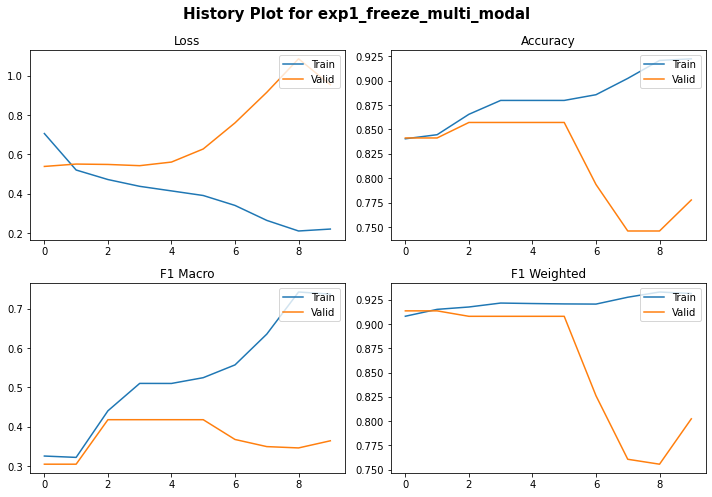

<Figure size 432x288 with 0 Axes>

In [51]:
## visualize and save manual plot image to png in checkpoint folder
visualize_history(dir_checkpoint, file_name)

### fine-tuning

 Fine-tune pre-trained BERT, ResNet weights

In [59]:
# Start training! (10 epochs)

dir_checkpoint='./checkpoint'
file_name='exp1_tuning'
checkpoint = CheckPoint(dir_checkpoint='./checkpoint', file_name=file_name)


for epoch in tqdm(range(1, EPOCHS+1)):
    start_time = timer()
    train_loss, train_acc, train_f1_macro, train_f1_weighted = train_epoch(model, optimizer, train_dataloader)
    #train_loss, train_acc = train_epoch(model, optimizer, train_dataloader)
    end_time = timer()
    
    valid_loss, valid_acc, valid_f1_macro, valid_f1_weighted = evaluate_epoch(model, valid_dataloader, test=False)
    
    print(f">>>>> Epoch {epoch} (time = {(end_time - start_time):.3f}s)")
    print(f"[Train] Loss: {train_loss:.4f}, Accuracy: {train_acc:.3f}, F1_macro: {train_f1_macro:.3f}, F1_weighted: {train_f1_weighted:.3f}")
    #print(f"[Train] Loss: {train_loss:.4f}, Accuracy: {train_acc:.3f}")
    print(f"[Valid] Loss: {valid_loss:.4f}, Accuracy: {valid_acc:.3f}, F1_macro: {valid_f1_macro:.3f}, F1_weighted: {valid_f1_weighted:.3f}")

    # checkpoint
    checkpoint.step(model, valid_loss, valid_acc, valid_f1_macro, valid_f1_weighted, epoch)
    
    log_dict = {'Train Loss': train_loss, 'Train Accuracy': train_acc, 'Train F1 Macro': train_f1_macro, 'Train F1 Weighted': train_f1_weighted,
                'Valid Loss': valid_loss, 'Valid Accuracy': valid_acc, 'Valid F1 Macro': valid_f1_macro, 'Valid F1 Weighted': valid_f1_weighted}
    
    #log_dict = {'Train Loss': train_loss, 'Train Accuracy': train_acc,
    #            'Valid Loss': valid_loss, 'Valid Accuracy': valid_acc, 'Valid F1 Macro': valid_f1_macro, 'Valid F1 Weighted': valid_f1_weighted}
    
    # history
    save_history(epoch, dir_checkpoint, file_name, log_dict)
    
    wandb.log(log_dict) ### wandb 페이지에 log 기록

  0%|                                                                                                                                                                                            | 0/10 [00:00<?, ?it/s]

>>>>> Epoch 1 (time = 47.330s)
[Train] Loss: 0.6835, Accuracy: 0.816, F1_macro: 0.390, F1_weighted: 0.865
[Valid] Loss: 0.8630, Accuracy: 0.667, F1_macro: 0.310, F1_weighted: 0.654
Model Save : Best Loss 9999.0000 -> 0.8630


 10%|██████████████████                                                                                                                                                                  | 1/10 [00:50<07:30, 50.10s/it]

>>>>> Epoch 2 (time = 47.058s)
[Train] Loss: 0.4717, Accuracy: 0.867, F1_macro: 0.486, F1_weighted: 0.911
[Valid] Loss: 0.5712, Accuracy: 0.841, F1_macro: 0.371, F1_weighted: 0.896
Model Save : Best Loss 0.8630 -> 0.5712


 20%|████████████████████████████████████                                                                                                                                                | 2/10 [01:41<06:46, 50.76s/it]

>>>>> Epoch 3 (time = 47.196s)
[Train] Loss: 0.4588, Accuracy: 0.878, F1_macro: 0.503, F1_weighted: 0.918
[Valid] Loss: 0.5467, Accuracy: 0.857, F1_macro: 0.418, F1_weighted: 0.908
Model Save : Best Loss 0.5712 -> 0.5467


 30%|██████████████████████████████████████████████████████                                                                                                                              | 3/10 [02:32<05:57, 51.10s/it]

>>>>> Epoch 4 (time = 47.294s)
[Train] Loss: 0.4669, Accuracy: 0.876, F1_macro: 0.504, F1_weighted: 0.918
[Valid] Loss: 0.5330, Accuracy: 0.857, F1_macro: 0.418, F1_weighted: 0.908
Model Save : Best Loss 0.5467 -> 0.5330


 50%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 5/10 [04:14<04:13, 50.78s/it]

>>>>> Epoch 5 (time = 47.406s)
[Train] Loss: 0.4578, Accuracy: 0.877, F1_macro: 0.502, F1_weighted: 0.919
[Valid] Loss: 0.5939, Accuracy: 0.857, F1_macro: 0.418, F1_weighted: 0.908


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 6/10 [05:03<03:21, 50.32s/it]

>>>>> Epoch 6 (time = 47.260s)
[Train] Loss: 0.4691, Accuracy: 0.869, F1_macro: 0.489, F1_weighted: 0.911
[Valid] Loss: 0.5829, Accuracy: 0.841, F1_macro: 0.415, F1_weighted: 0.884


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 7/10 [05:52<02:29, 49.95s/it]

>>>>> Epoch 7 (time = 47.167s)
[Train] Loss: 0.4580, Accuracy: 0.876, F1_macro: 0.495, F1_weighted: 0.915
[Valid] Loss: 0.5424, Accuracy: 0.857, F1_macro: 0.418, F1_weighted: 0.908


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 8/10 [06:42<01:39, 49.87s/it]

>>>>> Epoch 8 (time = 47.660s)
[Train] Loss: 0.4609, Accuracy: 0.875, F1_macro: 0.497, F1_weighted: 0.915
[Valid] Loss: 0.5636, Accuracy: 0.857, F1_macro: 0.418, F1_weighted: 0.908


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 9/10 [07:32<00:49, 49.91s/it]

>>>>> Epoch 9 (time = 47.852s)
[Train] Loss: 0.4441, Accuracy: 0.874, F1_macro: 0.499, F1_weighted: 0.915
[Valid] Loss: 0.5936, Accuracy: 0.857, F1_macro: 0.418, F1_weighted: 0.908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [08:22<00:00, 50.23s/it]

>>>>> Epoch 10 (time = 47.700s)
[Train] Loss: 0.4492, Accuracy: 0.876, F1_macro: 0.502, F1_weighted: 0.913
[Valid] Loss: 0.5997, Accuracy: 0.857, F1_macro: 0.418, F1_weighted: 0.908


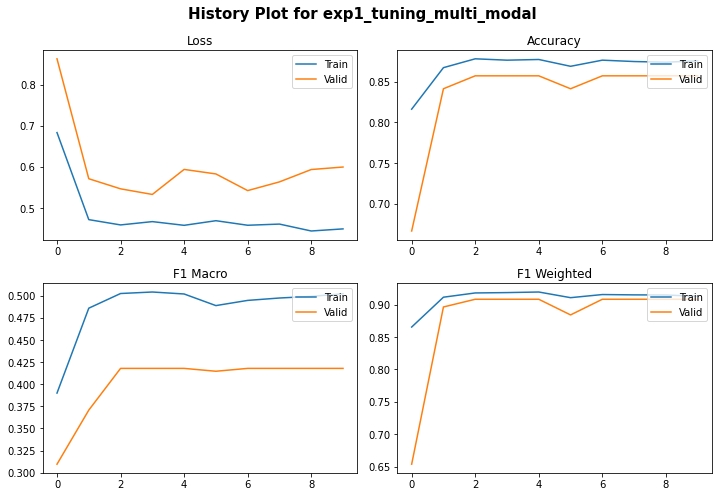

<Figure size 432x288 with 0 Axes>

In [60]:
## visualize and save manual plot image to png in checkpoint folder
visualize_history(dir_checkpoint, file_name)

---

## 4. Test

In [33]:
torch.manual_seed(0) #랜덤 시드 고정


# Load the tokenizer for the BERT model.
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create Dataset objects for train/validation sets.
test_dataset = MultiModal_Dataset(df=test_df, tokenizer=tokenizer, img_size=128)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 32)

weights = torch.load(f'{dir_checkpoint}/{file_name}_multi_modal.pth')

model = MultiModal_Classification(text_model_name = 'bert-base-uncased', text_trainable=False, image_trainable=False, projection_dim=256, num_class=3)
model = model.to(device)
model.load_state_dict(weights['model_state_dict'])

print('Load pretrained model')


Load pretrained model


### fine-tuning

In [36]:
test_loss, test_acc, test_f1_macro, test_f1_weighted, pred_labels, real_labels = evaluate_epoch(model, test_dataloader, test = True)
print(f"[Test] Loss: {test_loss:.4f}, Accuracy: {test_acc:.3f}, F1_macro: {test_f1_macro:.3f}, F1_weighted: {test_f1_weighted:.3f}")

[Test] Loss: 0.4976, Accuracy: 0.886, F1_macro: 0.513, F1_weighted: 0.916


In [40]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = list(label_map.keys())

# classification report
report = classification_report(real_labels.cpu().detach().numpy(), pred_labels.cpu().detach().numpy(), target_names=class_names)
print(report)

# confusion matrix
pd.DataFrame(confusion_matrix(real_labels.cpu().detach().numpy(), pred_labels.cpu().detach().numpy()),index=class_names, columns=class_names)

               precision    recall  f1-score   support

Contradictory       0.70      0.64      0.67        11
      Implies       0.00      0.00      0.00        11
 NoEntailment       0.90      0.99      0.94       118

     accuracy                           0.89       140
    macro avg       0.53      0.54      0.54       140
 weighted avg       0.81      0.89      0.85       140



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Contradictory,Implies,NoEntailment
Contradictory,7,0,4
Implies,2,0,9
NoEntailment,1,0,117


### freeze

In [34]:
test_loss, test_acc, test_f1_macro, test_f1_weighted, pred_labels, real_labels = evaluate_epoch(model, test_dataloader, test = True)
print(f"[Test] Loss: {test_loss:.4f}, Accuracy: {test_acc:.3f}, F1_macro: {test_f1_macro:.3f}, F1_weighted: {test_f1_weighted:.3f}")

[Test] Loss: 0.5966, Accuracy: 0.843, F1_macro: 0.329, F1_weighted: 0.890


In [35]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = list(label_map.keys())

# classification report
report = classification_report(real_labels.cpu().detach().numpy(), pred_labels.cpu().detach().numpy(), target_names=class_names)
print(report)

# confusion matrix
pd.DataFrame(confusion_matrix(real_labels.cpu().detach().numpy(), pred_labels.cpu().detach().numpy()),index=class_names, columns=class_names)

               precision    recall  f1-score   support

Contradictory       0.00      0.00      0.00        11
      Implies       0.00      0.00      0.00        11
 NoEntailment       0.84      1.00      0.91       118

     accuracy                           0.84       140
    macro avg       0.28      0.33      0.30       140
 weighted avg       0.71      0.84      0.77       140



,Contradictory,Implies,NoEntailment
Contradictory,0,0,11
Implies,0,0,11
NoEntailment,0,0,118
